# Irreversible first order reaction simulation

Irreversible first order reactions are perhaps the most common type of kinteic situations. The general form of these reactions is the following:

$$A \rightarrow B$$

The rate of change in the concentrations of each species in this system ([A] and [B]) is defined by a series of ordinary differential equations (ODEs). 

$$ \frac{d[A]}{dt} = -k[A] $$
$$ \frac{d[B]}{dt} = k[A] $$

Where $k$ is the forward rate constant for the given reaction. For these simple systems, analytical solutions to these equations are easily derived and can be found in any introductory chemistry text or [on the web]. For example, the integrated rate law for a first order reaction is as follows:

$$ [A] = [A]_{0}e^{-kt} $$

Where $[A]_0$ is the initial concentration of compound *A*. 

In the example below, we are going to fit some simulated first order kinetic data using traditional fitting techniques with the analytical solution above and with the module *ODEnlls*, which fits the kinetic data using numerical simulations of the reaction ODEs.

To start, we'll need to import some extra modules.

[on the web]: https://chem.libretexts.org/Core/Physical_and_Theoretical_Chemistry/Kinetics/Reaction_Rates/First-Order_Reactions

In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

The *ODEnlls* module only defines one object class **ODEnlls**, which we'll use here.

In [2]:
from ODEnlls import ODEnlls

## Traditional Analytical Solutions

Let's define a function that caculates our first order analytical solution. This saves us a lot of typing in the future, and we can use it for fitting later.

In [3]:
def first_order(times, c_A0, k1):
    return c_A0*np.exp(-k1*times)

Let's simulate this function to get a sense of how the data should look.

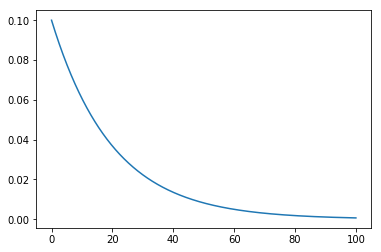

In [4]:
times = np.linspace(0, 100, 1000)
A0 = 0.1 # Initial concentration
k = 0.05 # rate constant
A = first_order(times, A0, k) # Concentrations of A at any time
plt.plot(times, A)

In order to simulate the behavior of the product, we must define a second analytical equation.

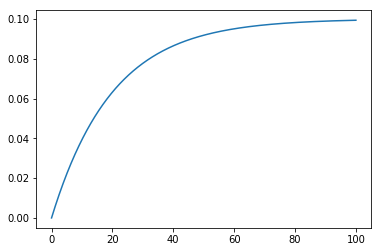

In [5]:
def first_order_back(times, c_A0, k1):
    return c_A0*(1 - np.exp(-k1*times))

B = first_order_back(times, A0, k)
plt.plot(times, B)

## ODEnlls Simulations

In order to use **ODEnlls**, we must create a plain text file that contains lines for all of the reactions we expect for the system. There are some rules for how these files should be formatted. 

1. Each reaction should be on its own line.
2. Compounds can have any name that you'd like; however, you may want to avoid names that are subsets of each other. For example, avoid `butane` and `isobutane`. In addition, do not use any of the following special characters, detailed below, in compound names. You will be using these names in some of the later code, so you might want to keep the names simple.
3. Compound names should be separated by `+` if they are on the same side of the reaction arrow. 
4. If two or more of the same compound are reacting/forming, write them as follows `n*compound_name`, where `n` is the number of identical compuonds, and `compound_name` is simply the name you want to use for the compound.
5. The starting materials and products should be separated by either `->` for irreversible reactions or `=` for equilibrium reactions.
6. Blank lines are ignored. Comment lines can be added as long as they begin with a `#` character.

In order to simulate a reaction file, I'll create a `io.StringIO` object that behaves like a typical Python file object that you would get with the `open` function. Here we'll just create a single irreversible reaction of compound *A* being transformed into compound *B*. 

In [6]:
rxn = 'A -> B'

f = io.StringIO('w+')
f.write(rxn)
f.seek(0)

0

Here we are creating an **ODEnlls** object instance, and using the `read_rxns` method to read our reaction "file". Alternatively, the name of the reaction file could be passed as a string to this function, which will internally generate the appropriate file object.

In [7]:
x = ODEnlls()
x.read_rxns(f)

After exectuting this function, several new attributes are created inside of our **ODEnlls** object. For example, the `rxns` attribute is simply a list of the reactions that were read in from the reaction file.

In [8]:
x.rxns

['A -> B']

There is a also another list attribute called `odes` that shows all of the ordinary differential equations for each chemcial species. To see how these ODEs line up with the different chemical species, we will print the ODEs with the associated compounds, which are in a semi-private compound list attirbuted named `_cpds`.  The ODEs have a lot of parentheses and multipliers, which are a result of the automated reaction processing. 

In [9]:
for cpd, ode in zip(x._cpds, x.odes):
    print('d['+cpd+']/dt =', ode)

d[A]/dt = 1.00*(-1*k1*(A))
d[B]/dt = 1.00*(k1*(A))


Most importantly, a table of simulation parameters is generated as a `Pandas.DataFrame` called `params`. There is a column for *guess* parameters, which will be optimized when we do fitting, and a column *fix* for parameters that will not change during fitting.

In [10]:
x.params

,guess,fix
A,NaN,NaN
B,NaN,NaN
k1,NaN,NaN


Initially, all of the parameters are set as empty `Numpy.nan` values. Every parameter will need to have either a *guess* or *fix* parameter associated with it. The **ODEnlls** object has a `set_param` method, which can assist in this process. (Alternatively, if you are familiar with Pandas DataFrames, you can set the values directly. They must be added as floating point values, though.)

The `set_param` method can be used in a couple of different ways. The first way is to provide a string name of the first compound followed by the associated value that you'd like to use. The default is to set this as a *guess* parameter. We'll see how to fix parameters later.

In [11]:
x.set_param('A', A0)
x.params

,guess,fix
A,0.1,NaN
B,NaN,NaN
k1,NaN,NaN


Alternatively, you can pass in a dictionary of paramters. They dictionary keys need to be compound names, and the values should be the associated parameter values.

In [12]:
param_dict = {'B': 0.0, 'k1': k} 
x.set_param(param_dict)
x.params

,guess,fix
A,0.10,NaN
B,0.00,NaN
k1,0.05,NaN


The **ODEnlls** object also has a `plot` method for visualizing simulations and data. The first argument to this method is a string that determines the plot type. In this case, we only want to visualize the ODE simulation, so we pass the `'sim'` argument. We can also set the times over which we want to plot the simulation using the `times` keyword argument. The `colorlines` keyword argument causes the simulation lines to be colored (otherwise they will both be black).

*Note*: The `plot` method uses Matplotlib internally to generate the plots. There are only `pyplot.plot` function calls, so if this is being used in an non-interactive environment, you'll need to use an explicit `pyplot.show` command, at the least. 

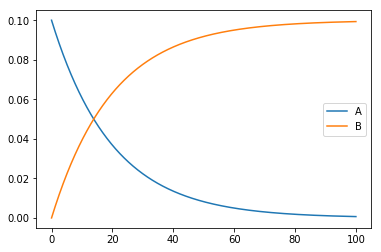

In [13]:
x.plot('sim', times=times, colorlines=True)

As you can see, using the ODE simulation generates concentration data for both compounds *A* and *B* simultaneously, which is a benefit to this method. 

The ODE simulations are identical to the analytical solutions, as we would expect.

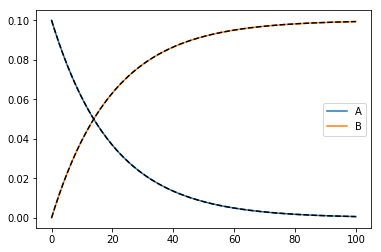

In [14]:
x.plot('sim', times=times, colorlines=True)
plt.plot(times, A, 'k--')
plt.plot(times, B, 'k--')